**importing libraries**

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense

**reading the CDR Value**

In [14]:
data = pd.read_csv("C:/Users/My/Desktop/output.csv") 
X, Y = data.values[:, :-1], data.values[:, -1]
print("Classes are:", np.unique(Y))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=7)


Classes are: [0. 1.]


**Training a K-means model based on the CDR Values**

In [15]:
num_clusters = len(np.unique(Y))  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train)

# Predict cluster labels
y_pred = kmeans.predict(X_test)


K-Means Clustering Accuracy: 92.16%


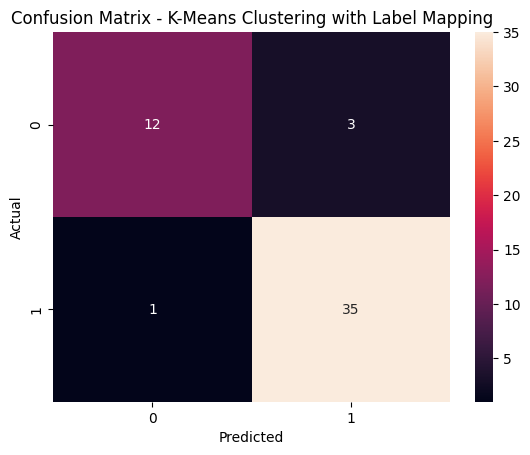

In [16]:
from scipy.stats import mode
import numpy as np

def map_cluster_labels(y_true, y_pred):
    cluster_labels = np.unique(y_pred)  
    new_labels = np.zeros_like(y_pred)  

    for cluster in cluster_labels:
        
        cluster_true_labels = y_true[y_pred == cluster]

        
        if len(cluster_true_labels) > 0:
            
            mode_result = mode(cluster_true_labels)

            # Handle both scalar and array cases
            if isinstance(mode_result.mode, np.ndarray):
                
                most_common_label = mode_result.mode[0]
            else:
                
                most_common_label = mode_result.mode


            new_labels[y_pred == cluster] = most_common_label
        else:
            print(f"Warning: No true labels found for cluster {cluster}.")

    return new_labels


# Map predicted clusters to true labels
mapped_labels = map_cluster_labels(Y_test, y_pred)

# Calculate accuracy
accuracy = (mapped_labels == Y_test).mean() * 100
print(f"K-Means Clustering Accuracy: {accuracy:.2f}%")

#Confusion Matrix
cm = confusion_matrix(Y_test, mapped_labels)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - K-Means Clustering with Label Mapping")
plt.show()

**Exatracting features using a CNN from Unseen images**


Reading the dataset

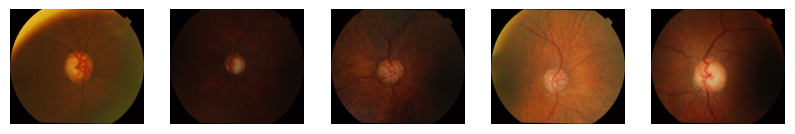

In [19]:
path = "C:/Users/My/Desktop/dataset_glaucoma/Img"
dataset_path = path

# Walk through the subdirectories and gather image paths
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_files.append(os.path.join(root, file))


if len(image_files) == 0:
    print("No image files found in the specified dataset path. Please check the folder content.")
else:
    # Display a few images
    plt.figure(figsize=(10, 10))
    num_images = min(5, len(image_files))
    for i in range(num_images):
        img = Image.open(image_files[i])
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

Reading the labels 

In [55]:
# Load the CSV to get labels
def load_labels_from_csv(csv_file):
    labels = []
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  
        for row in reader:
            label = row
            labels.append(label) 
    return labels

# Load images
def load_images(image_files, img_size=(224, 224)):
    images = []
    for image_path in image_files:
        filename = image_path.split('/')[-1]
        img = cv2.imread(image_path)
        img = cv2.resize(img, img_size) / 255.0  
        images.append(img)
    return np.array(images)

# Paths
csv_file = "C:/Users/My/Desktop/Labels.csv"  

# Load labels from CSV
labels = load_labels_from_csv(csv_file)

# Load data
X = load_images(image_files)
y = labels

**Training a designed CNN model for feature extraction**

In [56]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create a simple CNN model
base_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
])

# Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Extract features
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)

# Flatten features for SVM
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


**Training the Kmeans Model**

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


# Normalize the features (zero mean, unit variance)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reduce dimensionality to a more manageable size 
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
train_features_balanced, y_train_balanced = smote.fit_resample(train_features_pca, y_train)

# Re-run KMeans on the reduced features
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=500)
kmeans.fit(train_features_balanced)


test_cluster_labels = kmeans.predict(test_features_pca)


c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


K-Means Clustering Accuracy after Mapping: 70.59%


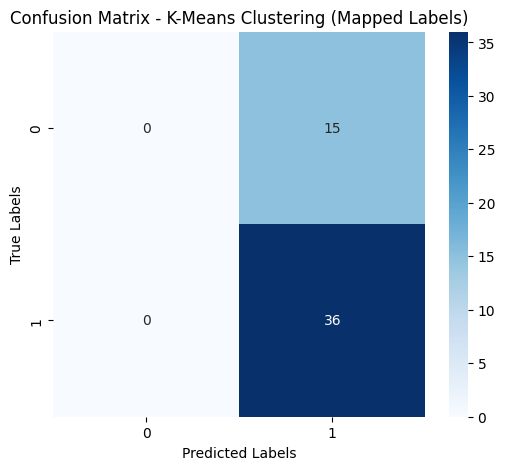

In [65]:
from scipy.stats import mode
import numpy as np

def map_cluster_labels(y_true, y_pred):
    """
    Maps predicted clusters to true labels using majority voting.
    """
    y_true = np.array(y_true, dtype=int)  # Convert to integer numpy array
    y_pred = np.array(y_pred, dtype=int)  # Convert to integer numpy array
    
    unique_clusters = np.unique(y_pred)
    mapped_labels = np.zeros_like(y_pred)

    for cluster in unique_clusters:
        indices = np.where(y_pred == cluster)
        cluster_true_labels = y_true[indices]

        if len(cluster_true_labels) > 0:
            # Find the most common label using mode
            most_common_label = mode(cluster_true_labels, keepdims=True).mode[0]
            mapped_labels[indices] = most_common_label
        else:
            print(f"Warning: Cluster {cluster} has no samples.")
    
    return mapped_labels



# Map predicted clusters to true labels
mapped_labels = map_cluster_labels(y_test, test_cluster_labels)


import numpy as np

# Convert y_test to a NumPy array
y_test = np.array(y_test, dtype=int)

# Calculate accuracy
accuracy = (mapped_labels == y_test.flatten()).mean() * 100
print(f"K-Means Clustering Accuracy after Mapping: {accuracy:.2f}%")


# Generate and plot confusion matrix
cm = confusion_matrix(y_test.flatten(), mapped_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - K-Means Clustering (Mapped Labels)")
plt.show()


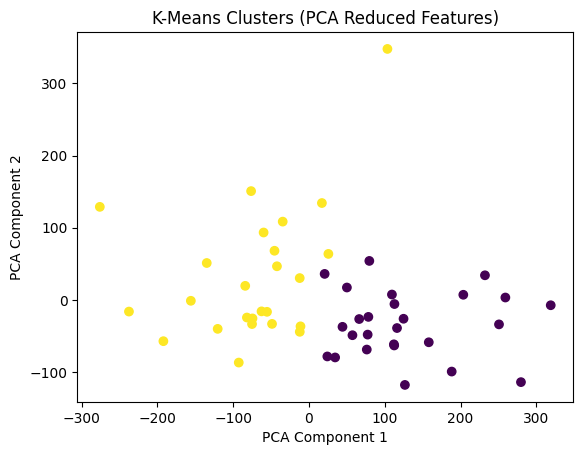

In [64]:
import matplotlib.pyplot as plt

plt.scatter(test_features_pca[:, 0], test_features_pca[:, 1], c=test_cluster_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA Reduced Features)')
plt.show()

**Training VGG16 model for feature extraction**

In [66]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)

# Flatten features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)



2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step


**Applying the K-means model**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE



# Normalize the features (zero mean, unit variance)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reduce dimensionality to a more manageable size (e.g., 100 components)
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
train_features_balanced, y_train_balanced = smote.fit_resample(train_features_pca, y_train)

# Re-run KMeans on the reduced features
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=500)
kmeans.fit(train_features_balanced)


test_cluster_labels = kmeans.predict(test_features_pca)




c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


K-Means Clustering Accuracy after Mapping: 70.59%


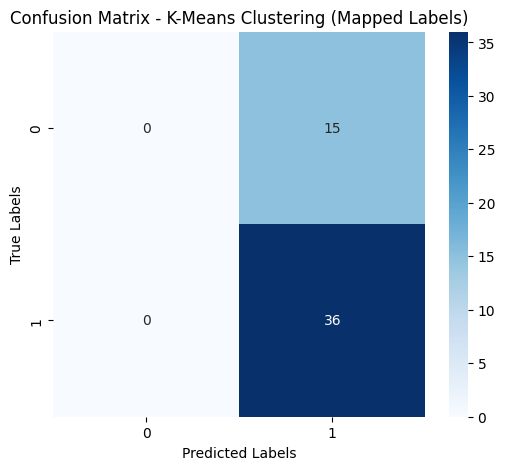

In [75]:
from scipy.stats import mode
import numpy as np

def map_cluster_labels(y_true, y_pred):
    """
    Maps predicted clusters to true labels using majority voting.
    """
    y_true = np.array(y_true, dtype=int)  # Convert to integer numpy array
    y_pred = np.array(y_pred, dtype=int)  # Convert to integer numpy array
    
    unique_clusters = np.unique(y_pred)
    mapped_labels = np.zeros_like(y_pred)

    for cluster in unique_clusters:
        indices = np.where(y_pred == cluster)
        cluster_true_labels = y_true[indices]

        if len(cluster_true_labels) > 0:
            # Find the most common label using mode
            most_common_label = mode(cluster_true_labels, keepdims=True).mode[0]
            mapped_labels[indices] = most_common_label
        else:
            print(f"Warning: Cluster {cluster} has no samples.")
    
    return mapped_labels



# Map predicted clusters to true labels
mapped_labels = map_cluster_labels(y_test, test_cluster_labels)


import numpy as np

# Convert y_test to a NumPy array
y_test = np.array(y_test, dtype=int)

# Calculate accuracy
accuracy = (mapped_labels == y_test.flatten()).mean() * 100
print(f"K-Means Clustering Accuracy after Mapping: {accuracy:.2f}%")


# Generate and plot confusion matrix
cm = confusion_matrix(y_test.flatten(), mapped_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - K-Means Clustering (Mapped Labels)")
plt.show()


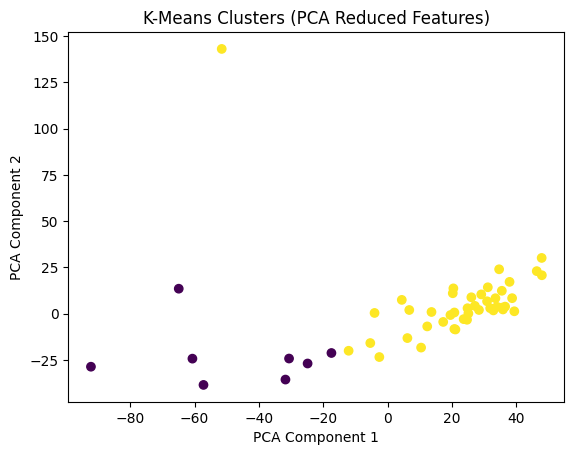

In [76]:
import matplotlib.pyplot as plt

plt.scatter(test_features_pca[:, 0], test_features_pca[:, 1], c=test_cluster_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA Reduced Features)')
plt.show()

# The Final Code using VGG16 to Extract the Features and K-means for Classification

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step
K-Means Clustering Accuracy: 79.21%


c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


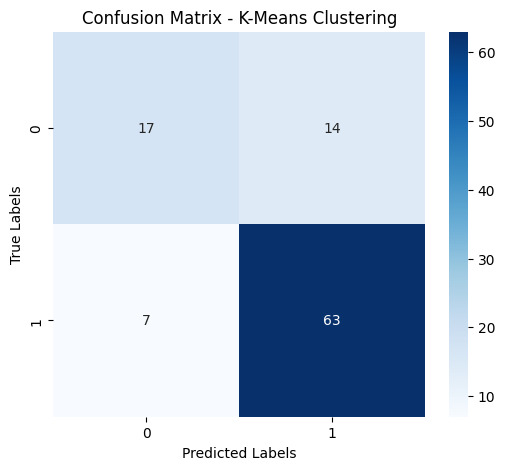

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load images
def load_images(image_files, img_size=(224, 224)):
    images = []
    for image_path in image_files:
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img)
        img = preprocess_input(img)  
        images.append(img)
    return np.array(images)

# Dataset paths
image_folder = "C:/Users/My/Desktop/dataset_glaucoma/Img"
label_csv = "C:/Users/My/Desktop/Labels.csv"

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg'))]

# Load labels
labels_df = pd.read_csv(label_csv)
labels = labels_df['Labels'].astype(int).tolist()  

assert len(image_files) == len(labels), "Mismatch between images and labels!"

# Load images
X_images = load_images(image_files)

# Use VGG16 for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x) 
model = Model(inputs=base_model.input, outputs=x)

features = model.predict(X_images)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features_pca, labels)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=500)
kmeans.fit(features_balanced)
cluster_labels = kmeans.predict(features_pca)

# Map cluster labels to true labels
from scipy.stats import mode

def map_cluster_labels(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    unique_clusters = np.unique(y_pred)
    mapped_labels = np.zeros_like(y_pred)

    for cluster in unique_clusters:
        indices = np.where(y_pred == cluster)
        cluster_true_labels = y_true[indices]

        if len(cluster_true_labels) > 0:
            # Find the most common label using mode
            most_common_label = mode(cluster_true_labels, keepdims=True).mode[0]
            mapped_labels[indices] = most_common_label

    return mapped_labels

# Map predicted clusters to true labels
mapped_labels = map_cluster_labels(labels, cluster_labels)

# Evaluate clustering
accuracy = accuracy_score(labels, mapped_labels)
print(f"K-Means Clustering Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(labels, mapped_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - K-Means Clustering")
plt.show()



# Concatenating the calculated CDRs with extracted features by CNN and using it as an input to the K-means

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step
K-Means Clustering Accuracy: 83.17%


c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


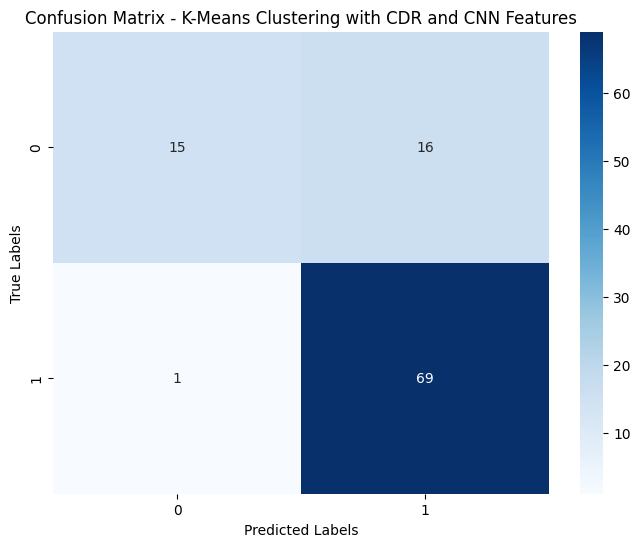

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load images
def load_images(image_files, img_size=(224, 224)):
    images = []
    for image_path in image_files:
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img)
        img = preprocess_input(img)  
        images.append(img)
    return np.array(images)

# Dataset paths
image_folder = "C:/Users/My/Desktop/dataset_glaucoma/Img"
label_csv = "C:/Users/My/Desktop/Labels.csv"
cdr_csv = "C:/Users/My/Desktop/output.csv"  

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg'))]

# Load labels
labels_df = pd.read_csv(label_csv)
labels = labels_df['Labels'].astype(int).tolist()  

# Load CDR values
cdr_data = pd.read_csv(cdr_csv)
cdr_values = cdr_data['Average'].values  

assert len(image_files) == len(labels) == len(cdr_values), "Mismatch between images, labels, and CDR values!"

# Load images
X_images = load_images(image_files)

# Use VGG16 for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  
model = Model(inputs=base_model.input, outputs=x)

features = model.predict(X_images)

# Concatenate CDR values with extracted features
cdr_values = cdr_values.reshape(-1, 1) 
features_combined = np.concatenate((features, cdr_values), axis=1)

# Normalize combined features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_combined)

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features_pca, labels)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=500)
kmeans.fit(features_balanced)
cluster_labels = kmeans.predict(features_pca)

# Map cluster labels to true labels
from scipy.stats import mode

def map_cluster_labels(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    unique_clusters = np.unique(y_pred)
    mapped_labels = np.zeros_like(y_pred)

    for cluster in unique_clusters:
        indices = np.where(y_pred == cluster)
        cluster_true_labels = y_true[indices]

        if len(cluster_true_labels) > 0:
            # Find the most common label using mode
            most_common_label = mode(cluster_true_labels, keepdims=True).mode[0]
            mapped_labels[indices] = most_common_label

    return mapped_labels

# Map predicted clusters to true labels
mapped_labels = map_cluster_labels(labels, cluster_labels)

# Evaluate clustering
accuracy = accuracy_score(labels, mapped_labels)
print(f"K-Means Clustering Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(labels, mapped_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - K-Means Clustering with CDR and CNN Features")
plt.show()

